In [2]:
import mesa
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        # Ensure agent is not giving money to itself
        cellmates.pop(cellmates.index(self))
        if len(cellmates) > 0:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height):
        super().__init__()
        self.num_agents = n
        # create the space
        self.grid = mesa.space.MultiGrid(width, height, True)
        # collect the output
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

In [4]:
model = MoneyModel(100, 10, 10)
for _ in range(20):
    model.step()

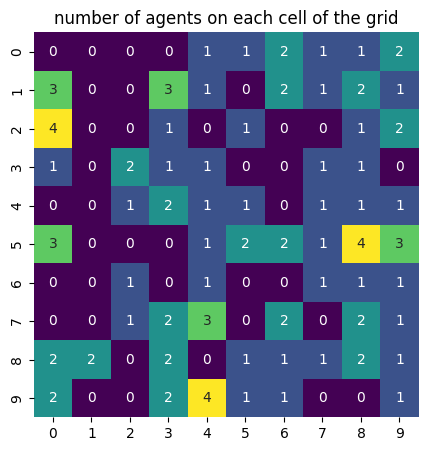

In [5]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="number of agents on each cell of the grid");

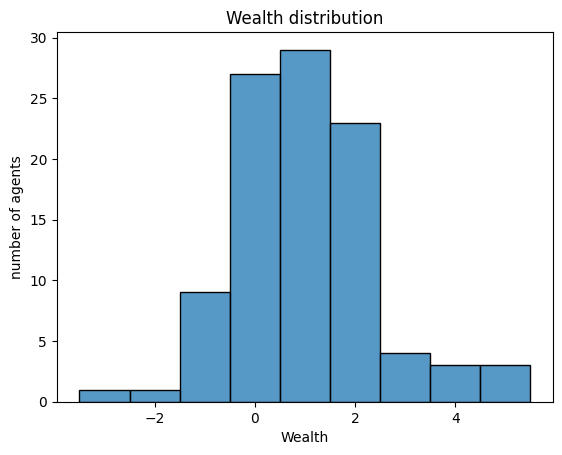

In [6]:
agent_wealth = [a.wealth for a in model.agents]
# Create a histogram with seaborn
g = sns.histplot(agent_wealth, discrete=True)
g.set(
    title="Wealth distribution", xlabel="Wealth", ylabel="number of agents"
);  # The semicolon is just to avoid printing the object representation

In [7]:
model = MoneyModel(100, 10, 10)
for _ in range(100):
    model.step()

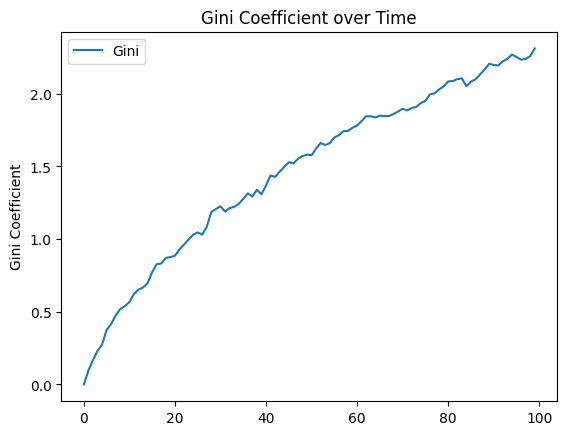

In [8]:
gini = model.datacollector.get_model_vars_dataframe()
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

In [9]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
1    1             1
     2             1
     3             1
     4             1
     5             1

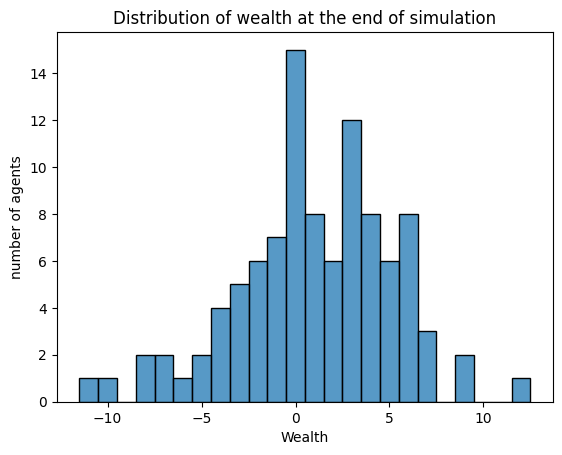

In [10]:
last_step = agent_wealth.index.get_level_values("Step").max()
end_wealth = agent_wealth.xs(last_step, level="Step")["Wealth"]
# Create a histogram of wealth at the last step
g = sns.histplot(end_wealth, discrete=True)
g.set(
    title="Distribution of wealth at the end of simulation",
    xlabel="Wealth",
    ylabel="number of agents",
);

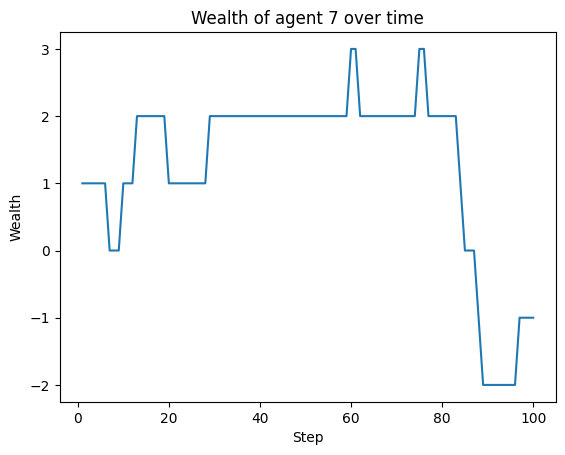

In [11]:
# Get the wealth of agent 7 over time
one_agent_wealth = agent_wealth.xs(7, level="AgentID")

# Plot the wealth of agent 7 over time
g = sns.lineplot(data=one_agent_wealth, x="Step", y="Wealth")
g.set(title="Wealth of agent 7 over time");

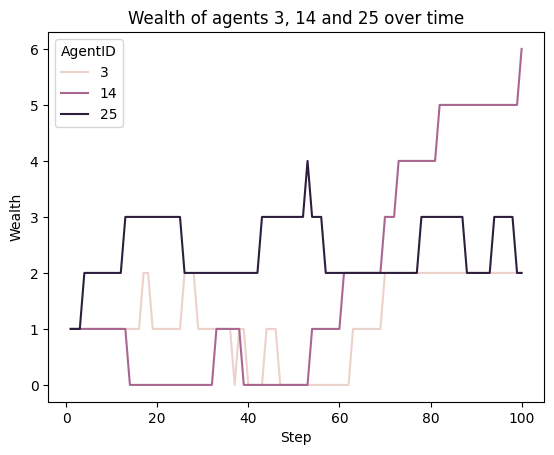

In [12]:
agent_list = [3, 14, 25]

# Get the wealth of multiple agents over time
multiple_agents_wealth = agent_wealth[
    agent_wealth.index.get_level_values("AgentID").isin(agent_list)
]
# Plot the wealth of multiple agents over time
g = sns.lineplot(data=multiple_agents_wealth, x="Step", y="Wealth", hue="AgentID")
g.set(title="Wealth of agents 3, 14 and 25 over time");

[Text(0.5, 1.0, 'Average wealth over time')]

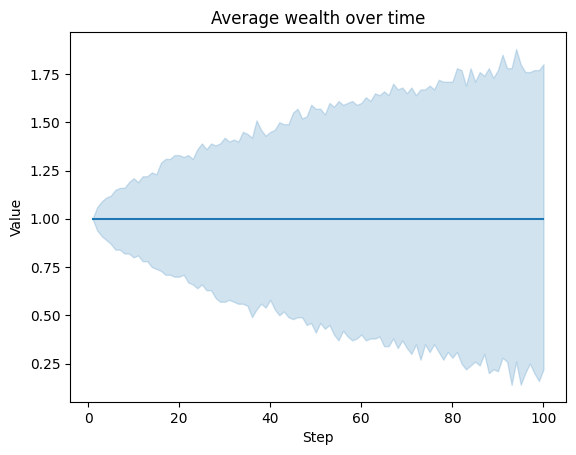

In [13]:
# Transform the data to a long format
agent_wealth_long = agent_wealth.T.unstack().reset_index()
agent_wealth_long.columns = ["Step", "AgentID", "Variable", "Value"]
agent_wealth_long.head(3)

# Plot the average wealth over time
g = sns.lineplot(data=agent_wealth_long, x="Step", y="Value", errorbar=("ci", 95))
g.set(title="Average wealth over time")

In [14]:
# save the model data (stored in the pandas gini object) to CSV
gini.to_csv("model_data.csv")

# save the agent data (stored in the pandas agent_wealth object) to CSV
agent_wealth.to_csv("agent_data.csv")

In [15]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        if self.wealth > 0:
            cellmates = self.model.grid.get_cell_list_contents([self.pos])
            # Ensure agent is not giving money to itself
            cellmates.pop(cellmates.index(self))
            if len(cellmates) > 0:
                other_agent = self.random.choice(cellmates)
                other_agent.wealth += 1
                self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = mesa.space.MultiGrid(width, height, True)

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

In [16]:
model = MoneyModel(100, 10, 10)
for _ in range(20):
    model.step()

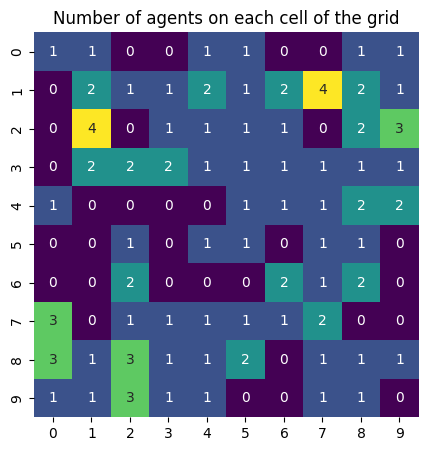

In [18]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
# Plot using seaborn, with a visual size of 5x5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(5, 5)
g.set(title="Number of agents on each cell of the grid");

In [20]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def give_money(self, poor_agents):
        if self.wealth > 0:
            other_agent = self.random.choice(poor_agents)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n):
        super().__init__()
        self.num_agents = n

        # Create agents
        MoneyAgent.create_agents(model=self, n=n)

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        # Get lists of rich and poor agents
        rich_agents = model.agents.select(lambda a: a.wealth >= 3)
        poor_agents = model.agents.select(lambda a: a.wealth < 3)
        # When there is rich agents only have them give money to the poor agents
        if len(rich_agents) > 0:
            rich_agents.shuffle_do("give_money", poor_agents)
        else:
            poor_agents.shuffle_do("give_money", poor_agents)

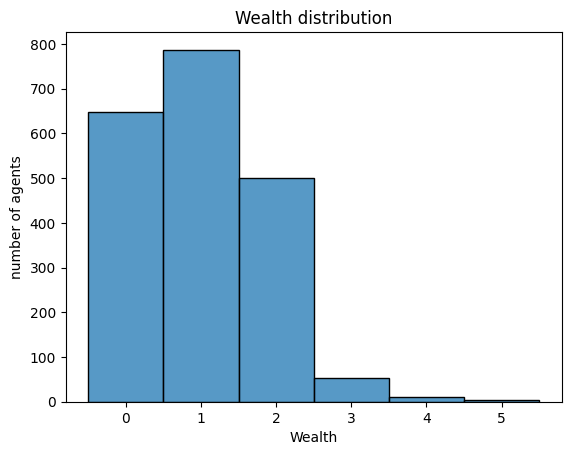

In [21]:
model = MoneyModel(100)
for _ in range(20):
    model.step()


data = model.datacollector.get_agent_vars_dataframe()
# Use seaborn
g = sns.histplot(data["Wealth"], discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

In [22]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model, ethnicity):
        super().__init__(model)
        self.wealth = 1
        self.ethnicity = ethnicity

    def give_money(self, similars):
        if self.wealth > 0:
            other_agent = self.random.choice(similars)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n):
        super().__init__()
        self.num_agents = n

        # Create a list of our different ethnicities
        ethnicities = ["Green", "Blue", "Mixed"]

        # Create agents
        MoneyAgent.create_agents(model=self, n=n, ethnicity=self.random.choice(ethnicities))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", "Ethnicity": "ethnicity"},
        )

    def step(self):
        self.datacollector.collect(self)
        # groupby returns a dictionary of the different ethnicities with a list of agents
        grouped_agents = model.agents.groupby("ethnicity")

        for ethnic, similars in grouped_agents:
            if ethnic != "Mixed":
                similars.shuffle_do("give_money", similars)
            else:
                similars.shuffle_do(
                    "give_money", self.agents
                )  # This allows mixed to trade with anyone

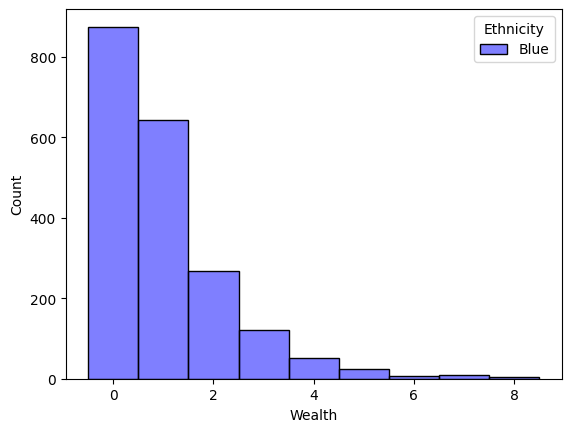

In [23]:
# Run the model
model = MoneyModel(100)
for _ in range(20):
    model.step()

# get the data
data = model.datacollector.get_agent_vars_dataframe()
# assign histogram colors
palette = {"Green": "green", "Blue": "blue", "Mixed": "purple"}
sns.histplot(data=data, x="Wealth", hue="Ethnicity", discrete=True, palette=palette)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

In [24]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.running = True

        # Create agents
        agents = MoneyAgent.create_agents(model=self, n=n)
        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(n,))
        y = self.rng.integers(0, self.grid.height, size=(n,))
        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", "Steps_not_given": "steps_not_given"},
        )

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.shuffle_do("give_money")


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1
        self.steps_not_given = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.pop(cellmates.index(self))
        if len(cellmates) > 0 and self.wealth > 0:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
            self.steps_not_given = 0
        else:
            self.steps_not_given += 1

In [25]:
params = {"width": 10, "height": 10, "n": range(5, 100, 5)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

  0%|          | 0/95 [00:00<?, ?it/s]

In [26]:
results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'n', 'Gini', 'AgentID',
       'Wealth', 'Steps_not_given'],
      dtype='object')


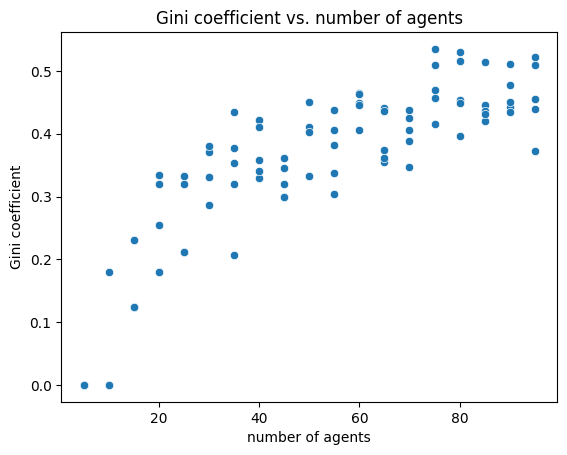

In [27]:
# Filter the results to only contain the data of one agent (the Gini coefficient will be the same for the entire population at any time) at the 100th step of each episode
results_filtered = results_df[(results_df.AgentID == 1) & (results_df.Step == 100)]
results_filtered[["iteration", "n", "Gini"]].reset_index(
    drop=True
).head()  # Create a scatter plot
g = sns.scatterplot(data=results_filtered, x="n", y="Gini")
g.set(
    xlabel="number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

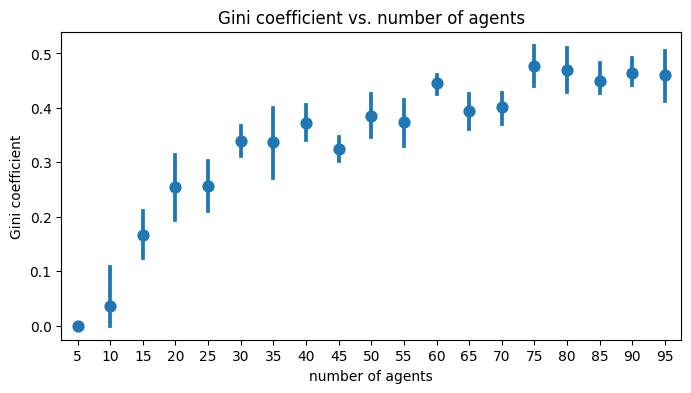

In [28]:
# Create a point plot with error bars
g = sns.pointplot(data=results_filtered, x="n", y="Gini", linestyle="None")
g.figure.set_size_inches(8, 4)
g.set(
    xlabel="number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

In [30]:
# First, we filter the results
one_episode_wealth = results_df[(results_df.n == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=10
    )
)
# For a prettier display we can also convert the data frame to html, uncomment to test in a Jupyter notebook
from IPython.display import display, HTML
display(HTML(one_episode_wealth.to_html(index=False, columns=['Step', 'AgentID', 'Wealth'], max_rows=25)))

 Step  AgentID  Wealth
    0      NaN     NaN
    1      1.0     1.0
    1      2.0     1.0
    1      3.0     1.0
    1      4.0     1.0
  ...      ...     ...
  100      6.0     1.0
  100      7.0     1.0
  100      8.0     1.0
  100      9.0     1.0
  100     10.0     1.0


Step,AgentID,Wealth
0,NaN,NaN
1,1.0,1.0
1,2.0,1.0
1,3.0,1.0
1,4.0,1.0
1,5.0,1.0
1,6.0,1.0
1,7.0,1.0
1,8.0,1.0
1,9.0,1.0


In [31]:

results_one_episode = results_df[
    (results_df.n == 10) & (results_df.iteration == 1) & (results_df.AgentID == 1)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=10))

 Step  Gini
    1   0.0
    2   0.0
    3   0.0
    4   0.0
    5   0.0
  ...   ...
   96   0.0
   97   0.0
   98   0.0
   99   0.0
  100   0.0


In [32]:
params = {"seed": None, "width": 10, "height": 10, "n": [5, 10, 20, 40, 80]}

results_5s = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=25,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,  # Important, otherwise the datacollector will only collect data of the last time step
    display_progress=True,
)

results_5s_df = pd.DataFrame(results_5s)

  0%|          | 0/125 [00:00<?, ?it/s]

In [33]:
# Again filter the results to only contain the data of one agent (the Gini coefficient will be the same for the entire population at any time)
results_5s_df_filtered = results_5s_df[(results_5s_df.AgentID == 1)]
results_5s_df_filtered.head(3)

,RunId,iteration,Step,seed,width,height,n,Gini,AgentID,Wealth,Steps_not_given
1,0,0,1,None,10,10,5,0.0,1.0,1.0,0.0
6,0,0,2,None,10,10,5,0.0,1.0,1.0,1.0
11,0,0,3,None,10,10,5,0.0,1.0,1.0,0.0


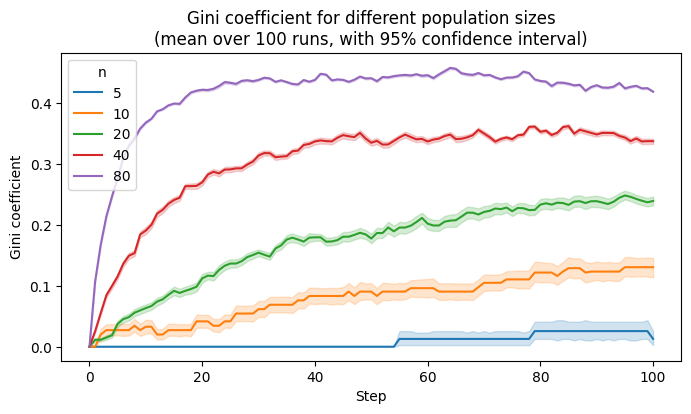

In [34]:
# Create a lineplot with error bars
g = sns.lineplot(
    data=results_5s_df,
    x="Step",
    y="Gini",
    hue="n",
    errorbar=("ci", 95),
    palette="tab10",
)
g.figure.set_size_inches(8, 4)
plot_title = "Gini coefficient for different population sizes\n(mean over 100 runs, with 95% confidence interval)"
g.set(title=plot_title, ylabel="Gini coefficient");

In [35]:
# Calculate the mean of the wealth and the number of consecutive rounds for all agents in each episode
agg_results_df = (
    results_5s_df.groupby(["iteration", "n", "Step"])
    .agg({"Wealth": "mean", "Steps_not_given": "mean"})
    .reset_index()
)
agg_results_df.head(3)

,iteration,n,Step,Wealth,Steps_not_given
0,0,5,0,NaN,NaN
1,0,5,1,1.0,0.0
2,0,5,2,1.0,1.0


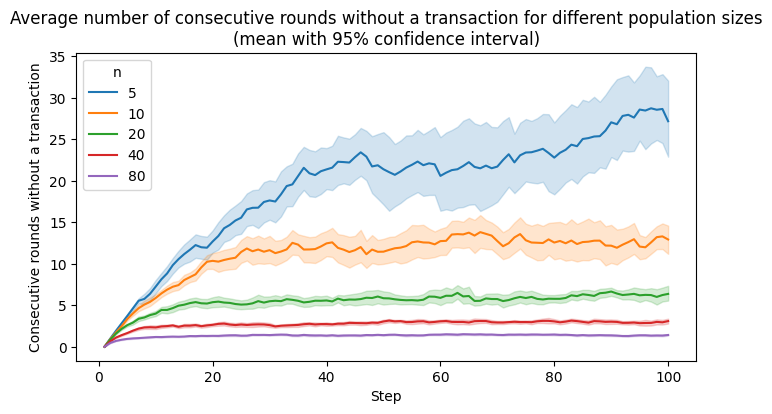

In [36]:
# Create a line plot with error bars
g = sns.lineplot(
    data=agg_results_df, x="Step", y="Steps_not_given", hue="n", palette="tab10"
)
g.figure.set_size_inches(8, 4)
g.set(
    title="Average number of consecutive rounds without a transaction for different population sizes\n(mean with 95% confidence interval)",
    ylabel="Consecutive rounds without a transaction",
);